# Varying Viscosity on Ensemble-Wide Mean

# 1. Load Dataset

In [1]:
import xarray as xr
import gcsfs
gcs = gcsfs.GCSFileSystem(token=None, access='read_only')

In [2]:
snapshots1ka = xr.open_zarr(gcs.get_mapper('gs://ldeo-glaciology/paleo_ensemble/snapshots1ka.zarr'))
snapshots1ka = snapshots1ka.chunk(chunks={'time':1})

In [3]:
# Add these codes to decrease CPU and memory use, which avoids the workers from being killed.
from dask.distributed import Client
import dask_gateway

gateway = dask_gateway.Gateway()

# Close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
         cluster = gateway.connect(c.name)
         cluster.shutdown()  

# Increase worker memory
options = gateway.cluster_options()
options.worker_memory = 16

cluster = gateway.new_cluster(cluster_options=options)

[]


In [4]:
# Start up cloud cluster with 20 workers
cluster.scale(20)
client = Client(cluster)

# 2. Varying viscosity

In [5]:
# Define section
x_p = [-1.5e6, -0.7e6]
y_p = [1.5e6, 0]

In [15]:
def extract_profile1(visc):
    import numpy as np
    # Define the x coordinates for the 1000 points between the two selected points
    x = np.linspace(x_p[0], x_p[1], 1000)
    # Define the y coordinates for the 1000 points between the two selected points
    y = np.linspace(y_p[0], y_p[1], 1000)

    # Create xarray datasets
    x = xr.DataArray(x, dims="number")
    y = xr.DataArray(y , dims="number")
    
    # Ice type advanced interpolation
    ice = snapshots1ka.mask.isel(time=124, par_visc=visc).mean({"par_esia","par_ppq","par_prec"}).interp(x=x, y=y).values
        
    # GL position
    print("GL position", np.max(np.where(ice > 2.5)))
    I_gl = np.max(np.where(ice > 2.5))
    x_g = x[I_gl]
    y_g = y[I_gl]
    
    print("x coordinate:", x_g)
    print("y coordinate:", y_g)
    
    # Visualize GL position
    import matplotlib.pyplot as plt
    snapshots1ka.mask.isel(time=124, par_visc=visc).mean({"par_esia","par_ppq","par_prec"}).plot(x='x',y='y',size = 5)
    plt.plot(x_p,y_p,color="red", lw=3)
    plt.plot(x[I_gl], y[I_gl], color="blue", markersize=10,marker="o") 
    plt.savefig('my_plot.png')

In [16]:
def extract_profile2(visc):
    import numpy as np
    # Define the x coordinates for the 1000 points between the two selected points
    x = np.linspace(x_p[0], x_p[1], 1000)
    # Define the y coordinates for the 1000 points between the two selected points
    y = np.linspace(y_p[0], y_p[1], 1000)

    # Create xarray datasets
    x = xr.DataArray(x, dims="number")
    y = xr.DataArray(y , dims="number")
    
    # Ice type advanced interpolation
    ice = snapshots1ka.mask.isel(time=124, par_visc=visc).mean({"par_esia","par_ppq","par_prec"}).interp(x=x, y=y).values
        
    # GL position
    I_gl = np.max(np.where(ice > 2.5))
    x_g = x[I_gl]
    y_g = y[I_gl]
    
    # Create a list that has the same number of elements as x
    distance = list(range(len(x)))
    GLx = x[I_gl].item()
    GLy = y[I_gl].item()

    for i in range(0,I_gl):
        dist = (x[i].item()-GLx)**2 + (y[i].item()-GLy)**2
        distance[i] = np.sqrt(dist) /1000

    for i in range(I_gl, len(x)):
        dist = (x[i].item()-GLx)**2 + (y[i].item()-GLy)**2
        distance[i] = -np.sqrt(dist) / 1000

    # Bedrock surface elevation advanced interpolation
    bed = snapshots1ka.topg.isel(time=124, par_visc=visc).mean({"par_esia","par_ppq","par_prec"}).interp(x=x, y=y).values
    
    # Ice thickness advanced interpolation
    ice = snapshots1ka.thk.isel(time=124, par_visc=visc).mean({"par_esia","par_ppq","par_prec"}).interp(x=x, y=y).values
    
    # Ice upper surface advanced interpolation
    surface = snapshots1ka.usurf.isel(time=124, par_visc=visc).mean({"par_esia","par_ppq","par_prec"}).interp(x=x, y=y).values
    
    # Lower level
    low = surface - ice
    
    # Plot cross section
    import matplotlib.pyplot as plt
    plt.plot(distance, bed, color="black", label="Bedrock Surface Elevation")
    plt.plot(distance, surface, color="blue", label="Ice Upper Surface Elevation")
    plt.plot(distance, low, color="blue", linestyle="--")
    plt.axhline(y = 0, color = 'black', linestyle = '--')
    plt.fill_between(distance, surface, low, color='aqua')
    plt.xlabel("Distance from Present-Day GL (km)")
    plt.ylabel("Elevation (m a.s.l.)")
    plt.title("Weddell Sea Sector (0 kyr BP)")
    plt.legend()
    plt.show()

## Viscosity = 1.0e20

GL position 247
x coordinate: <xarray.DataArray ()>
array(-1302202.2022022)
y coordinate: <xarray.DataArray ()>
array(1129129.12912913)


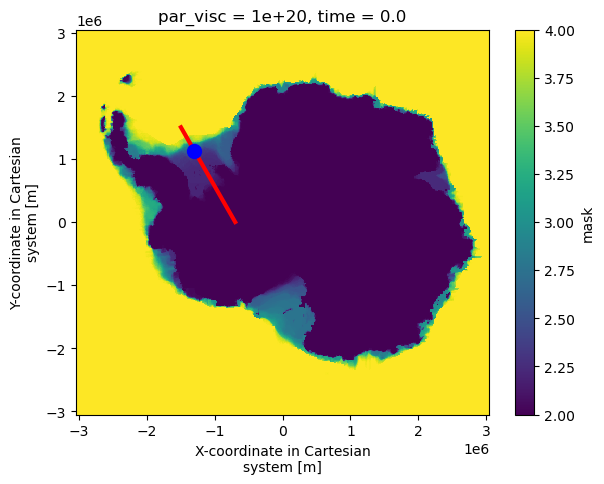

In [17]:
extract_profile1(0)

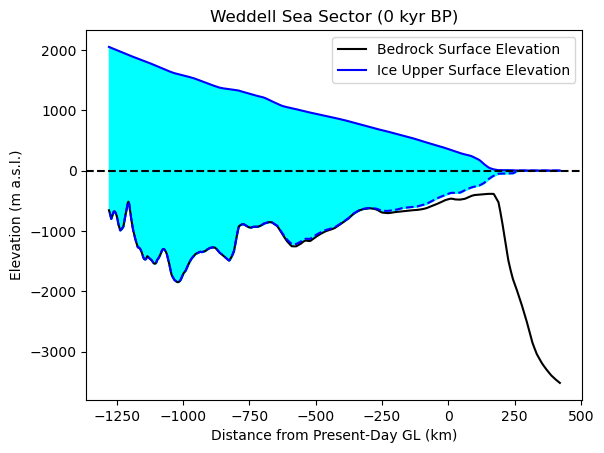

In [18]:
extract_profile2(0)

## Viscosity = 5.0e20

GL position 760
x coordinate: <xarray.DataArray ()>
array(-891391.39139139)
y coordinate: <xarray.DataArray ()>
array(358858.85885886)


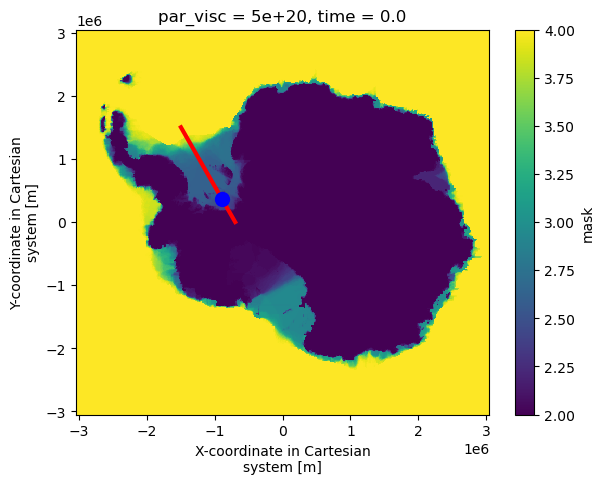

In [19]:
extract_profile1(1)

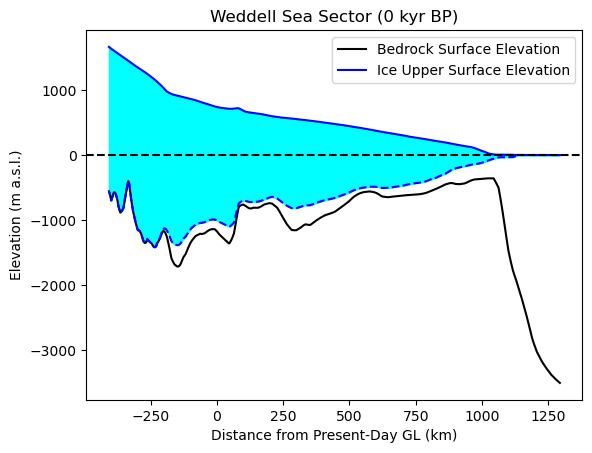

In [20]:
extract_profile2(1)

## Viscosity = 2.5e21

GL position 899
x coordinate: <xarray.DataArray ()>
array(-780080.08008008)
y coordinate: <xarray.DataArray ()>
array(150150.15015015)


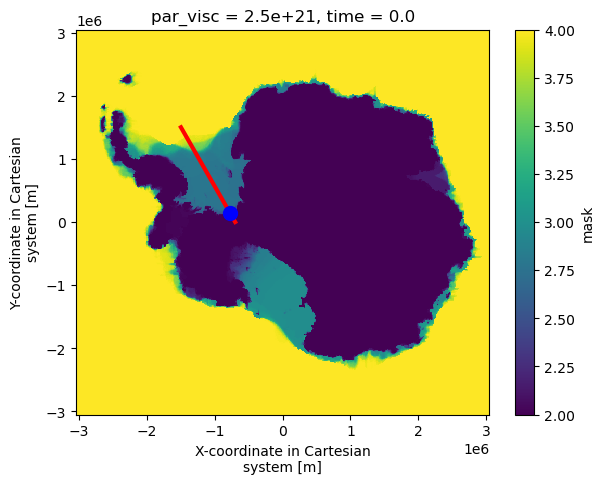

In [21]:
extract_profile1(2)

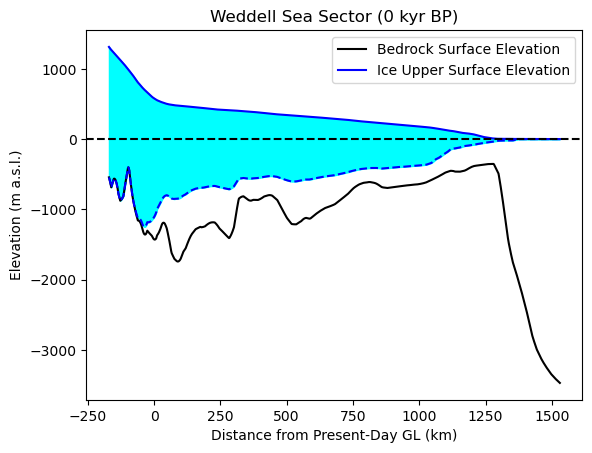

In [25]:
extract_profile2(2)

## Viscosity = 1.0e22

GL position 892
x coordinate: <xarray.DataArray ()>
array(-785685.68568569)
y coordinate: <xarray.DataArray ()>
array(160660.66066066)


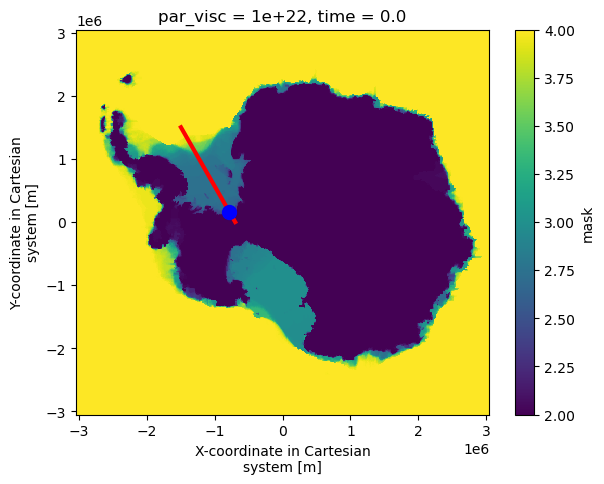

In [26]:
extract_profile1(3)

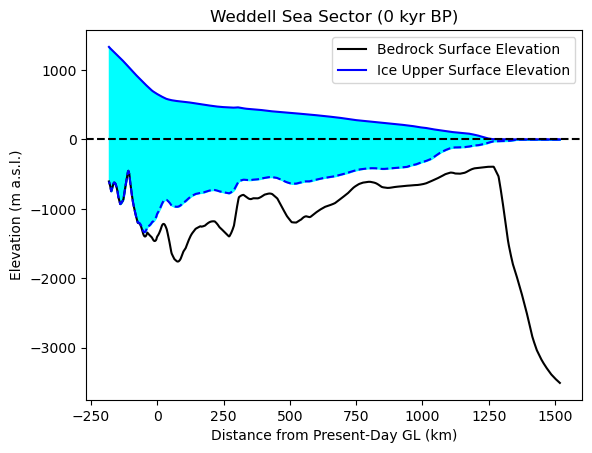

In [27]:
extract_profile2(3)

When the position of the grounding line and the ice volume are compared, the grounding line for the lowest viscosity ($\mu$ = 1.0e20 Pa s) scenario extended the furthest and the ice volume was also the largest on average. When the viscoisty was raised to 5.0e20 Pa s, the grounding line retreated largely. However, the ice volume was was still large because ice at the base of the ice shelf was not extensively lost. This is inferred to be because of the butressing of the ice shelf by the bedrock and its blockage of the warm deep water. Features of the Henry Ice Rise is observed, and there is also a sign of buttressing at roughly 600 m from the grounding line. When the viscosity was raised to 2.5e21 Pa s, the grounding line retreated by a small distance, and there was a clear decrease in the volume of the ice. Since the bedrock topography is not distinctly different in the $\mu$ = 5.0e20 Pa s and 2.5e21 Pa s scenarios, it is inferred that the $\mu$ = 2.5e21 Pa s scenario could not sustain its ice because the rebounding speed of the lithosphere was slower than the threshold require to reverse the retreating trend. Interestingly, however, the grounding line advanced slightly when the viscosity was raised to 1e22 Pa s, and the ice volume also increased marginally. This observation was unexpected because it deviates from the existing trend. However, when the ice type figures are compared, the ice sheet area at the Ross Sea is detectably larger in the $\mu$ = 2.5e21 Pa s scenario than in the $\mu$ = 1.0e22 Pa s scenario. Therefore, I infer that the deviation from the trend at $\mu$ = 1.0e22 Pa s is likely due to regional variation, and that the overall trend in ice sheet volume is a decreasing trend with increasing viscosity. 